In [16]:
import math
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
def histo_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    assert (imgs.shape[1] == 1)  # check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = cv2.equalizeHist(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = clahe.apply(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs - imgs_mean) / imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (
                    np.max(imgs_normalized[i]) - np.min(imgs_normalized[i]))) * 255
    return imgs_normalized

def adjust_gamma_batch(imgs, gamma=1.0):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i, 0] = cv2.LUT(np.array(imgs[i, 0], dtype=np.uint8), table)
    return new_imgs

def rgb2gray(rgb):
    assert (len(rgb.shape) == 4)  # 4D arrays
    assert (rgb.shape[1] == 3)
    bn_imgs = rgb[:, 1, :, :] * 0.75 + rgb[:, 2, :, :] * 0.25
    bn_imgs = np.reshape(bn_imgs, (rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

def preprocess_batch(data):
    assert (len(data.shape) == 4)
    assert (data.shape[1] == 3)  # Use the original images
    train_imgs = rgb2gray(data)
    # my preprocessing:
    train_imgs = dataset_normalized_batch(train_imgs)
    train_imgs = clahe_equalized_batch(train_imgs)
    train_imgs = adjust_gamma_batch(train_imgs, 1.2)
    return train_imgs

def make_patches(images, size=64, offset_y=0, offset_x=0):
    """
    Split images into patches for processing with optional offset.
    
    Args:
        images: ndarray, shape (N, C, H, W)
        size: block size (patch dimensions)
        offset_y: vertical offset from multiples of size (0 to size-1)
        offset_x: horizontal offset from multiples of size (0 to size-1)
    
    Returns:
        patches: ndarray, shape (num_patches, C, size, size)
        info: metadata tuple for reconstruction
    """
    images = np.asarray(images)
    N, C, H, W = images.shape
    
    # Validate offsets
    offset_y = max(0, min(offset_y, size - 1))
    offset_x = max(0, min(offset_x, size - 1))
    
    # Calculate number of blocks needed considering offset
    nH = math.ceil((H - offset_y) / size)
    nW = math.ceil((W - offset_x) / size)
    
    # Calculate required padding
    required_H = offset_y + nH * size
    required_W = offset_x + nW * size
    
    padH = max(0, required_H - H)
    padW = max(0, required_W - W)
    
    # Pad images
    padded = np.pad(images, ((0,0),(0,0),(0,padH),(0,padW)), mode='constant')
    
    patches = []
    for n in range(N):
        for i in range(nH):
            for j in range(nW):
                y = offset_y + i * size
                x = offset_x + j * size
                block = padded[n, :, y:y+size, x:x+size]
                patches.append(block)
    
    patches = np.stack(patches, axis=0)
    info = (H, W, nH, nW, padded.shape, offset_y, offset_x)
    return patches, info

def reconstruct_from_patches(patches, info, size=64):
    """
    Reconstruct images from patches with offset support.
    
    Args:
        patches: ndarray, shape (num_patches, C, size, size)
        info: metadata tuple from make_patches
        size: block size
    
    Returns:
        reconstructed images: ndarray, shape (N, C, H, W)
    """
    if len(info) == 7:  # New format with offsets
        H, W, nH, nW, padded_shape, offset_y, offset_x = info
    else:  # Old format without offsets (backward compatibility)
        H, W, nH, nW, padded_shape = info
        offset_y, offset_x = 0, 0
    
    N = padded_shape[0]
    C = padded_shape[1]
    padded_H, padded_W = padded_shape[2], padded_shape[3]
    
    # Initialize reconstruction arrays
    recon = np.zeros(padded_shape, dtype=patches.dtype)
    counts = np.zeros(padded_shape, dtype=np.int32)
    
    idx = 0
    for n in range(N):
        for i in range(nH):
            for j in range(nW):
                y = offset_y + i * size
                x = offset_x + j * size
                recon[n, :, y:y+size, x:x+size] += patches[idx]
                counts[n, :, y:y+size, x:x+size] += 1
                idx += 1
    
    # Avoid division by zero
    counts[counts == 0] = 1
    recon = recon / counts
    
    # Crop back to original dimensions
    return recon[:, :, :H, :W]
def remove_islands(image, minsize=50):
    """
    Remove small islands (connected components) from a binary image.
    
    Args:
        image: binary image (2D array)
        minsize: minimum size of connected components to keep
    
    Returns:
        cleaned_image: binary image with small islands removed
    """
    assert len(image.shape) == 2, "Input must be a 2D binary image"
    
    # Find connected components
    num_labels, labels_im = cv2.connectedComponents(image.astype(np.uint8), connectivity=8)
    
    # Create an output image
    cleaned_image = np.zeros_like(image, dtype=np.uint8)
    
    for label in range(1, num_labels):  # Skip label 0 (background)
        component_size = np.sum(labels_im == label)
        if component_size >= minsize:
            cleaned_image[labels_im == label] = 1
    
    return cleaned_image


In [17]:
def lbce_dice_loss(y_true, y_pred, eps=1e-6):
    """
    y_true: ground‐truth mask, shape (B, H, W, 1), values in {0,1}
    y_pred: predicted mask logits or probabilities, same shape
    """
    # flatten spatial dims to compute N and n per sample
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1))
    y_pred_f = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1))
    
    # per‐sample sums
    n = tf.reduce_sum(y_true_f, axis=1)                       # shape (B,)
    N = tf.cast(tf.shape(y_true_f)[1], tf.float32)           # scalar
    
    # 1) binary cross‐entropy per sample
    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f)  # shape (B,)
    
    # 2) dice loss per sample
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)      # shape (B,)
    dice_coef = (2. * intersection + eps) / (n + tf.reduce_sum(y_pred_f, axis=1) + eps)
    dice_loss = 1. - dice_coef                                     # shape (B,)
    
    # 3) weighting term per sample
    w_bce  = (N - n) / N    # shape (B,)
    w_dice = n     / N      # shape (B,)
    
    # 4) combined loss, then mean over batch
    loss_per_sample = w_bce * bce + w_dice * dice_loss            # shape (B,)
    return tf.reduce_mean(loss_per_sample)
custom = {
    # 'CascadeUnet': CascadeUnet,
    'lbce_dice_loss': lbce_dice_loss,
    # 'combined_loss': combined_loss,
    # 'dice_coef': dice_coef,

}

model = tf.keras.models.load_model(
    "model8_4no2",
    # onnly use weights

    custom_objects=custom
)

Preprocessed image shape: (1, 1, 480, 960)
Visit counts computed.


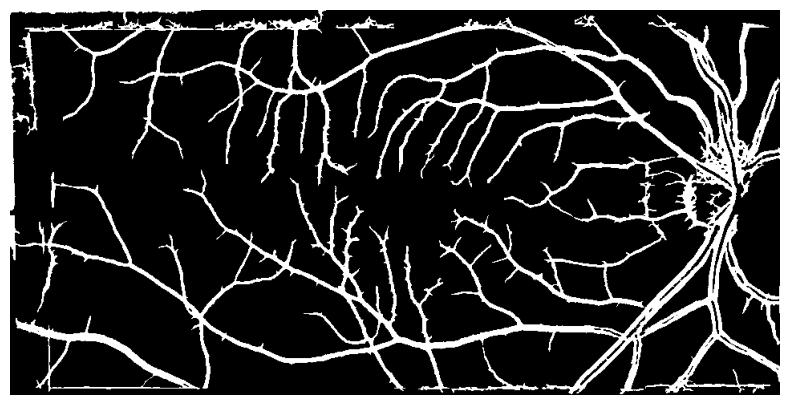

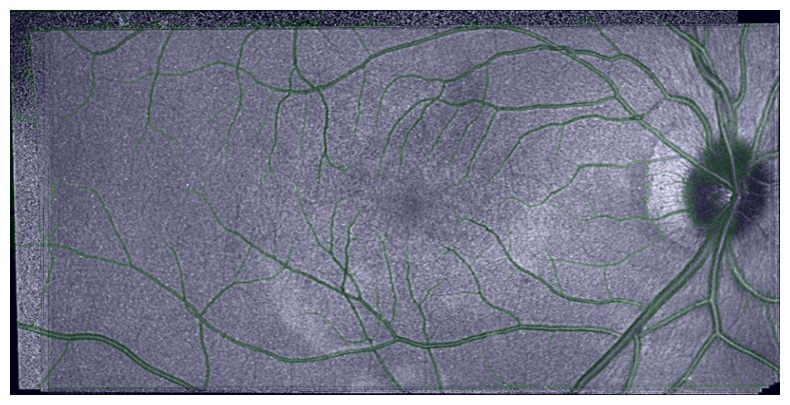

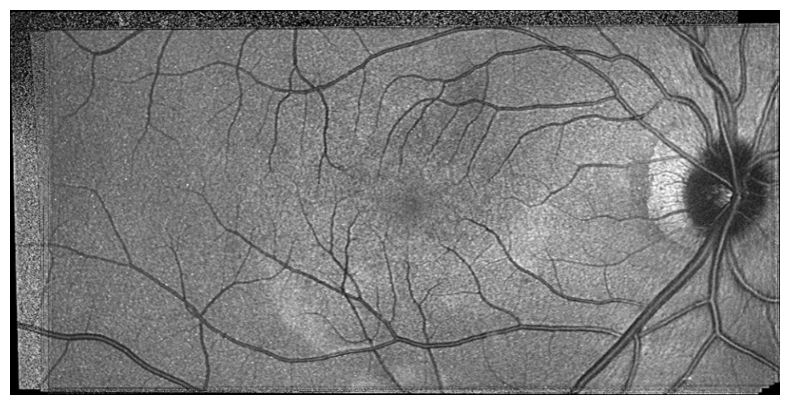

Processing time: 1.64 seconds
percentage of pixels predicted as positive: 14.40993923611111
This image is likely a good image.


In [37]:
# %pip install onnxruntime
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np
import cv2
import matplotlib.pyplot as plt

def process_and_predict_image(
    image_path,
    patch_size=64,
    resize_shape=(960, 480),
    offsets=None,
    session=None,          # <-- pass an onnxruntime.InferenceSession
    plot=True,
    threshold=0.5
):
    """
    Requires the following helpers to exist in your environment:
      - preprocess_batch(NCHW_batch) -> NCHW_batch
      - make_patches(NCHW_batch, size, offset_y, offset_x) -> (patches_NCHW, info)
      - reconstruct_from_patches(patches_NCHW, info, size) -> NCHW image
      - remove_islands(binary_2d_array, minsize)
    """
    if session is None:
        raise ValueError("Please pass an onnxruntime.InferenceSession via `session`.")

    if offsets is None:
        offsets = [(0, 0), (24, 24)]

    # --- helpers -------------------------------------------------------------
    def get_pixel_visit_counts_from_offsets(image_shape, patch_size, offsets):
        H, W = image_shape
        dummy = np.zeros((1, 1, H, W), dtype=np.uint8)
        total_counts = np.zeros((1, 1, H, W), dtype=np.int32)

        for offset_y, offset_x in offsets:
            _, info = make_patches(dummy, size=patch_size, offset_y=offset_y, offset_x=offset_x)
            recon = reconstruct_from_patches(
                np.ones((info[2] * info[3], 1, patch_size, patch_size), dtype=np.uint8),
                info, size=patch_size
            )
            total_counts += recon.astype(np.int32)

        return total_counts[0, 0]

    def _infer_expected_layout_and_name(sess):
        # Detect the single input’s name and expected layout (NCHW vs NHWC)
        inp = sess.get_inputs()[0]
        name = inp.name
        shape = inp.shape  # may contain None/strings for dynamic dims
        layout = "NHWC"  # sensible default

        if isinstance(shape, (list, tuple)) and len(shape) == 4:
            c1 = shape[1]
            c3 = shape[3]
            # If either dimension is clearly 1 or 3, assume that’s channels
            if c1 in (1, 3):
                layout = "NCHW"
            elif c3 in (1, 3):
                layout = "NHWC"
        return name, layout

    def _to_float01(x):
        # Ensure float32 in [0,1]
        x = x.astype(np.float32, copy=False)
        # If values look like 0..255, normalize; otherwise assume already normalized
        if x.max() > 1.5:
            x = x / 255.0
        return x

    # ------------------------------------------------------------------------

    # Load and preprocess image (to NCHW because your patch code expects NCHW)
    image = cv2.imread(image_path)
    image = cv2.resize(image, resize_shape)
    image_save = image.copy()

    image = np.expand_dims(image, axis=0)      # (N, H, W, C)
    image = image.transpose(0, 3, 1, 2)        # -> (N, C, H, W)
    image = preprocess_batch(image)            # user-defined

    print(f"Preprocessed image shape: {image.shape}")  # (1, C, H, W)

    visits = get_pixel_visit_counts_from_offsets(image.shape[2:], patch_size, offsets)
    print("Visit counts computed.")

    input_name, expected_layout = _infer_expected_layout_and_name(session)

    predicted_images = []
    for (x_off, y_off) in offsets:
        # Patches come out as NCHW
        patches, info = make_patches(image, size=patch_size, offset_y=y_off, offset_x=x_off)

        # Prepare input batch for ONNX model
        if expected_layout == "NHWC":
            to_model = patches.transpose(0, 2, 3, 1)  # NCHW -> NHWC
        else:  # NCHW expected
            to_model = patches

        to_model = _to_float01(to_model)

        # Run ONNX inference
        outputs = session.run(None, {input_name: to_model})
        preds = outputs[0]

        # Normalize preds to NCHW for reconstruction
        if preds.ndim == 4:
            if preds.shape[1] in (1, 3):        # NCHW
                preds_nchw = preds
            elif preds.shape[-1] in (1, 3):     # NHWC
                preds_nchw = preds.transpose(0, 3, 1, 2)
            else:
                # Unknown 4D layout; assume NHWC as fallback
                preds_nchw = preds.transpose(0, 3, 1, 2)
        elif preds.ndim == 3:
            # (N, H, W) -> add channel dim
            preds_nchw = preds[:, None, :, :]
        else:
            raise ValueError(f"Unexpected ONNX output shape: {preds.shape}")

        # Reconstruct full-size prediction for this offset
        recon = reconstruct_from_patches(preds_nchw, info, size=patch_size)
        recon = recon.squeeze().astype(np.float32)  # -> (H, W)

        predicted_images.append(recon)

    # Blend offset predictions by visit counts
    sum_predictions = np.sum(predicted_images, axis=0)

    visits = visits.astype(np.float32)
    visits[visits == 0] = 1.0

    full_pred = sum_predictions / visits
    full_pred = (full_pred > threshold).astype(np.float32)
    full_pred = remove_islands(full_pred, minsize=250)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.imshow(full_pred, cmap='gray')
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.axis("off")
        plt.imshow(image_save, cmap='gray')
        plt.imshow(full_pred, cmap='winter', alpha=0.1)
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.imshow(image_save, cmap='gray')
        plt.axis("off")
        plt.show()

    return full_pred



# Example usage
if __name__ == "__main__":
    import time
    session = ort.InferenceSession(r"C:\Users\NateLy\retina\model8_4no2.onnx", providers=["CPUExecutionProvider"])

    image_path = r"H:\Retinal_Intelligence\slo_1.2.826.0.1.3680043.8.498.62411439281042085551480857579010767351.jpg"
    # image_path = r"C:\Users\NateLy\Downloads\elka_00.tif"
    # image_path = r"C:\Users\NateLy\retina\testimgs\epy_img_20220828_1143_38_alligned.bmp"
    patch_size = 64
    resize_shape = (960, 480)  # Resize shape for the input image
    offsets = [(0, 0), (24,24)]  # Offsets for patch extraction
    threshold = 0.5  # Use a threshold for binary prediction
    start = time.time()
    full_pred = process_and_predict_image(image_path, patch_size, resize_shape, offsets, session, threshold=threshold)
    print(f"Processing time: {time.time() - start:.2f} seconds")
    mean_white = np.mean(full_pred) * 100
    print("percentage of pixels predicted as positive:", mean_white)
    # if below percentage threshold     
    if mean_white > 10:
        print("This image is likely a good image.")
    else:
        print("This image is likely a bad image.")